# The effect of speed humps on collision rates

The objective of this notebook is to visualize and measure the effect speed humps have on collision rates in New York City. When looking at collision data from NYC in a previous notebook, I noticed that roads with speed humps did not necesasrily have a lower collision rate than those without them. This may presumably be explained by the observation that most roads that do not have speed humps are safer roads in the first place: speed humps are usually installed when there is a reason to install them. It would be obviously wrong to conclude that speed humps have no effect on road safety, but a different strategy is needed to measure their impact.

In this notebook, I will focus on roads which currently have speed humps and will compare their weekly collision rates before and after the speed humps were installed. This approach does yield the expected result: speed humps do reduce collision rates. Moreover, it appears that the relationship between the weekly collision rates before and after speed humps were installed is roughly linear.

## Data Preparation

In [3]:
import matplotlib.pyplot as plt

plt.style.use("customstyle.mplstyle")

In [4]:
import pandas as pd
from pathlib import Path

DATA_FOLDER = Path("../data")

collisions = pd.read_pickle(DATA_FOLDER / "final_dataset.pkl")

In [5]:
collisions["collision_rate_per_length"] *= 1000
collisions_difference = (
    collisions[collisions["has_humps"]][["physicalid", "collision_rate_per_length"]]
    .rename(columns={"collision_rate_per_length": "collisions_per_week_after"})
    .join(
        collisions[~collisions["has_humps"]][
            ["physicalid", "collision_rate_per_length"]
        ]
        .rename(columns={"collision_rate_per_length": "collisions_per_week_before"})
        .set_index("physicalid"),
        on="physicalid",
        how="left",
    )
).dropna()

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlelocation"] = "left"

In [9]:
collisions_difference.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2594 entries, 276 to 91666
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   physicalid                  2594 non-null   int64  
 1   collisions_per_week_after   2594 non-null   float64
 2   collisions_per_week_before  2594 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 81.1 KB


## Comparison of streets before and after speed hump installation

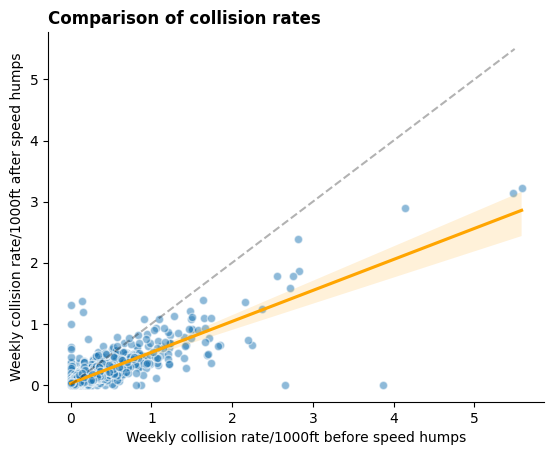

In [8]:
fig, ax = plt.subplots(1, 1)
sns.regplot(
    data=collisions_difference,
    x="collisions_per_week_before",
    y="collisions_per_week_after",
    # ax=ax[0],
    scatter_kws={"alpha": 0.5, "edgecolors": "white"},
    line_kws={"color": "orange"},
)
ax.plot([0, 5.5], [0, 5.5], c="black", linestyle="dashed", alpha=0.3)
# ax.plot([0, 6e-4], [0, 6e-4], c="black", linestyle="dashed", alpha=0.3)

ax.set_title("Comparison of collision rates")
# ax.set_xbound(lower=-1e-4, upper=4e-3)
# ax.set_ybound(lower=-1e-4, upper=4e-3)


ax.set_xlabel("Weekly collision rate/1000ft before speed humps")
ax.set_ylabel("Weekly collision rate/1000ft after speed humps")
plt.show()

The plot above shows the weekly collision rates after speed humps were installed against the rates before their installation. Each blue dot represents a road in New York City where humps are now present (and, as mentioned before, have not been installed within one year from now or from the earliest reported crash) and at least one collision occurred between July 2012 and now. The light grey dashed line is the diagonal. If installing speed humps reduces collision rates, we should see more blue dots below this line than above. Indeed, that is what we see. Finally, the orange line is the least squares regression line.

There appears to exist a linear relationship in the plot above. The Pearson correlation coefficients confirm this:

In [7]:
collisions_difference[
    ["collisions_per_week_before", "collisions_per_week_after"]
].corr()

,collisions_per_week_before,collisions_per_week_after
collisions_per_week_before,1.000000,0.837375
collisions_per_week_after,0.837375,1.000000


The linear coefficient is approximately 0.5, suggesting that modern speed hump installations have decreased collision rates by half.

In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(
    collisions_difference[["collisions_per_week_before"]],
    collisions_difference["collisions_per_week_after"],
)
lin_reg.coef_[0]

0.507050742210648